<a href="https://colab.research.google.com/github/sarahaptumich/capstone/blob/shaptonstall/SIC_Ranking_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Settle in the Cypher (SIC) Breakdancer Ranking System
We will me using the dataset provided by SIC to implement Elo abd Glicko ranking systems.


*   **Elo Ranking**: is a very popular ranking methodology using in chess.It works as follow:
    - Each player is awarded some starting' points, in this case 1500.
    - After a game, points are transferred from the losing player to the winning player. The amount of points transferred depends on the probability of each player winning the game, which is calculated based on their current ratings.
    - K-Factor: The K-factor controls the rate at which a player's rating changes. Higher K-factors allow more points to be transferred per game, leading to faster changes in ratings.

*   **Glicko2 Ranking** an enhancement of the Glicko system, assesses player strengths in games like chess. Each player has a rating (R), rating deviation (RD), indicating the reliability, and a volatility score (σ) reflecting expected rating fluctuations.  Incorporating results against others to adjust both rating and RD. The system introduces more dynamics by accounting for the uncertainty in a player’s rating through RD and adjusting for unexpected game outcomes via volatility, making it very suitable for environments with varying player activity and engagement levels.



In [ ]:
#Mount google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install skelo

In [ ]:
import sys


In [ ]:
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta
from sklearn.decomposition import PCA, KernelPCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import FactorAnalysis
import joblib
from sklearn.preprocessing import LabelEncoder
from skelo.model.elo import EloEstimator
from sklearn.metrics import classification_report
from sklearn.calibration import calibration_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from skelo.model.glicko2 import Glicko2Estimator
import random


In [ ]:
#load files
trivium= pd.read_csv('./datasets/trivium_scorecard.csv')
webscraping = pd.read_excel('./datasets/Webscraping.xlsx', sheet_name=None)
webscraping.keys()

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


dict_keys(['Events and8', 'Events', 'Events WDSF', 'Battles Trivium', 'Battles and8 Threefold', 'Battles and8 Single Slider', 'Battles and8 Round by Round', 'Battles and8 Traditional', 'Research Questions', 'Notes', 'Notes Columns'])

In [ ]:
#Load battle winners
#threefold
threefold = webscraping['Battles and8 Threefold']
threefold.rename(columns={'Unnamed: 0':'Event', 'Unnamed: 1': 'Category', 'breaker 1': 'breaker 1 (red)', 'breaker 2': 'breaker 2 (blue)'}, inplace=True)
threefold[['Event', 'Category']] = threefold[['Event', 'Category']].fillna(method='ffill')
#Trivium
trivium=webscraping['Battles Trivium']
trivium.rename(columns={'Unnamed: 0':'Event', 'Unnamed: 1': 'Category'}, inplace=True)
trivium[['Event', 'Category']]= trivium[['Event', 'Category']].fillna(method='ffill')
#traditional
traditional = webscraping['Battles and8 Traditional']
traditional.rename(columns={'Unnamed: 0':'Event', 'Unnamed: 1': 'Category'}, inplace=True)
traditional[['Event', 'Category']] = traditional[['Event', 'Category']].fillna(method='ffill')

In [ ]:
tr=traditional[['Event', 'Category', 'breaker 1 (red)', 'breaker 2 (blue)', 'winner']].copy()
th=threefold[['Event', 'Category', 'breaker 1 (red)', 'breaker 2 (blue)', 'winner']].copy()
tv=trivium[['Event', 'Category', 'breaker 1 (red)', 'breaker 2 (blue)', 'winner']].copy()

dataframes = [('traditional', tr), ('threefold', th), ('trivium', tv)]

# Create an empty list to store modified dataframes
appended_dfs = []

# Iterate to create a combined dataframe
for name, dframe in dataframes:
    dframe['Original_DF'] = name
    dframe['Battle_ID'] = dframe.index
    appended_dfs.append(dframe)
appendedBattles = pd.concat(appended_dfs, ignore_index=True)


In [ ]:
eventsAnd8=webscraping['Events and8'][1:].copy()
new_header= eventsAnd8.iloc[0]
eventsAnd8=eventsAnd8.drop(1)
eventsAnd8.columns = new_header
eventsAnd8.rename(columns={'Name':'Event'}, inplace=True)
eventsAnd8.drop_duplicates(subset=['Event'], inplace=True)

eventsWDSF = webscraping['Events WDSF'][1:].copy()
new_header = eventsWDSF.iloc[0]
eventsWDSF = eventsWDSF.drop(1)
eventsWDSF.columns = new_header
eventsWDSF.rename(columns={'Name': 'Event'}, inplace=True)
eventsWDSF.drop_duplicates(subset=['Event'], inplace=True)

Events = webscraping['Events'][1:].copy()
new_header = Events.iloc[0]
Events = Events.drop(1)
Events.columns = new_header
Events.rename(columns={'Name':'Event'}, inplace=True)
Events.drop_duplicates(subset=['Event'], inplace=True)

combined_events = pd.concat([eventsAnd8, eventsWDSF, Events], ignore_index=True)

In [ ]:
#add battle date
appendedBattles=pd.merge(appendedBattles, combined_events[['Date', 'Event']], on='Event', how='left')
appendedBattles['loser'] = np.where(appendedBattles['winner'] == appendedBattles['breaker 1 (red)'], appendedBattles['breaker 2 (blue)'], appendedBattles['breaker 1 (red)'])
appendedBattles[['winner', 'loser']]=appendedBattles[['winner', 'loser']].astype(str)
battlesNotide=appendedBattles[appendedBattles['winner']!='Tie'].copy()

In [ ]:
#Format battles data into format reconized by skelo, instead of distinguishing between winners and losers, it labels one player as "player1" and the other as "player2"
#and assigns a binary label (1 for player1 winning and 0 for player2 winning).
def load_data(df):
    #addapted from skelo docs example "tennis training" https://pypi.org/project/skelo/
    df["Date"] = pd.to_datetime(df['Date'])
    order_mask = (df["winner"] < df["loser"])
    df["p1"] = ""
    df["p2"] = ""
    df["label"] = 1
    df.loc[order_mask, "p1"] = df.loc[order_mask, "winner"]
    df.loc[~order_mask, "p1"] = df.loc[~order_mask, "loser"]
    df.loc[order_mask, "p2"] = df.loc[order_mask, "loser"]
    df.loc[~order_mask, "p2"] = df.loc[~order_mask, "winner"]
    df.loc[~order_mask, "label"] = 0

    return df

In [ ]:
battlesNotide= load_data(battlesNotide)

In [ ]:
boys = battlesNotide[(battlesNotide['Category'].str.contains('Boy')) | (battlesNotide['Category'].str.contains('Men'))]
girls= battlesNotide[(battlesNotide['Category'].str.contains('Girl')) | (battlesNotide['Category'].str.contains('Women'))]
others = battlesNotide[~battlesNotide.index.isin(boys.index) & ~battlesNotide.index.isin(girls.index)]

boys.shape[0], girls.shape[0],others.shape[0], battlesNotide.shape[0]== (boys.shape[0]+ girls.shape[0]+others.shape[0])

(1386, 851, 336, True)

In [ ]:
def fit_model(X):
    #adapted from skelo docss example Tennis Ranking https://pypi.org/project/skelo/
    X_subset = X[['Date', 'p1', 'p2', 'label']]
    model = EloEstimator(
        key1_field="p1",
        key2_field="p2",
        timestamp_field="Date",
        initial_time=min(X['Date'])
    )
    fitted_model = model.fit(X_subset, X_subset["label"])

    return fitted_model

In [ ]:
def plot_top_ratings(ax, ratings_frame, title):
    #adapted from skelo docss example Tennis Ranking https://pypi.org/project/skelo/
    ts_est = ratings_frame.pivot_table(index='valid_from', columns='key', values='rating').ffill()
    idx = ts_est.iloc[-1].sort_values().index[-5:]
    ts_est.loc[:, idx].plot(ax=ax)
    ax.set_xlabel('Date')
    ax.set_ylabel('Rating')
    ax.set_title(f'Top 5 Ratings Over Time - {title}')
    ax.legend(title='Player')
    ax.grid(True)

In [ ]:
X_boy= boys[['Date', 'p1', 'p2', 'label']]
X_girl= girls[['Date', 'p1', 'p2', 'label']]
X_other= others[['Date', 'p1', 'p2', 'label']]

In [ ]:
g_model=fit_model(X_girl)
b_model=fit_model(X_boy)
o_model=fit_model(X_other)

In [ ]:
boy_elo_rank= b_model.rating_model.to_frame()
girl_elo_rank=g_model.rating_model.to_frame()
other_elo_rank=o_model.rating_model.to_frame()

In [ ]:
boy_elo_current=boy_elo_rank[(boy_elo_rank['valid_to'].isnull())].sort_values(by='rating', ascending=False)
boy_top10=boy_elo_current[(boy_elo_rank['valid_from']>= '2023-01-01')].nlargest(10, 'rating')
girl_elo_current = girl_elo_rank[(girl_elo_rank['valid_to'].isnull())].sort_values(by='rating', ascending=False)
girl_top10 = girl_elo_current[(girl_elo_rank['valid_from'] >= '2023-01-01')].nlargest(10, 'rating')
other_elo_current = other_elo_rank[(other_elo_rank['valid_to'].isnull())].sort_values(by='rating', ascending=False)
other_top10 = other_elo_current[(other_elo_current['valid_from']>= '2023-01-01')].nlargest(10, 'rating')

<ipython-input-20-f6b1ed5a7d06>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  boy_top10=boy_elo_current[(boy_elo_rank['valid_from']>= '2023-01-01')].nlargest(10, 'rating')
<ipython-input-20-f6b1ed5a7d06>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  girl_top10 = girl_elo_current[(girl_elo_rank['valid_from'] >= '2023-01-01')].nlargest(10, 'rating')


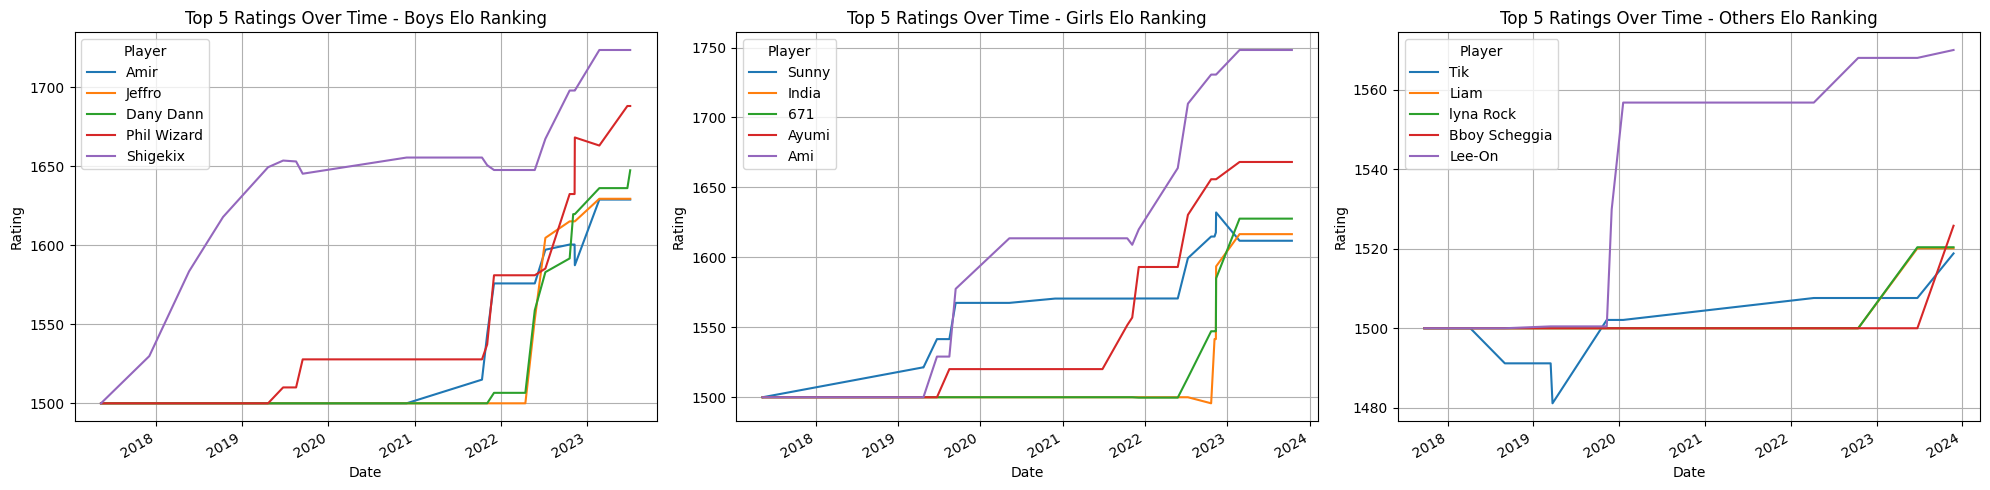

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot each model's top ratings horizontally
plot_top_ratings(axes[0], boy_elo_rank[boy_elo_rank['key'].isin(boy_top10['key'].to_list())], 'Boys Elo Ranking')
plot_top_ratings(axes[1], girl_elo_rank[girl_elo_rank['key'].isin(girl_top10['key'].to_list())], 'Girls Elo Ranking')
plot_top_ratings(axes[2], other_elo_rank[other_elo_rank['key'].isin(other_top10['key'].to_list())], 'Others Elo Ranking')
plt.tight_layout()
plt.show()

In [ ]:
print(classification_report(X_girl["label"], g_model.predict(X_girl)))

              precision    recall  f1-score   support

           0       0.57      0.71      0.63       382
           1       0.70      0.56      0.62       469

    accuracy                           0.63       851
   macro avg       0.63      0.63      0.63       851
weighted avg       0.64      0.63      0.63       851



In [ ]:
print(classification_report(X_boy["label"], b_model.predict(X_boy)))

              precision    recall  f1-score   support

           0       0.55      0.77      0.64       694
           1       0.62      0.37      0.47       692

    accuracy                           0.57      1386
   macro avg       0.59      0.57      0.56      1386
weighted avg       0.59      0.57      0.56      1386



In [ ]:
print(classification_report(X_other["label"], o_model.predict(X_other)))

              precision    recall  f1-score   support

           0       0.52      0.85      0.65       176
           1       0.47      0.15      0.23       160

    accuracy                           0.51       336
   macro avg       0.50      0.50      0.44       336
weighted avg       0.50      0.51      0.45       336



### Predict from random match
We will use the girls dataset to predict the winner in a fantasy match

In [ ]:
#create a list with all female breakers
unique_p1 = X_girl['p1'].unique()
unique_p2 = X_girl['p2'].unique()
set_p1 = set(unique_p1)
set_p2 = set(unique_p2)
combined_unique = list(set_p1.union(set_p2))

In [ ]:
#randomly select 2 breakers for a match
random_names = random.sample(combined_unique, 2)
random_names

['Ramona', 'Sayora']

In [ ]:
#Create a future match
data = {
    'Date': ['2024-04-17'],
    'p1': [random_names[0]],
    'p2': [random_names[1]]
}
predicting_df = pd.DataFrame(data)
predicting_df['Date'] = pd.to_datetime(predicting_df['Date'])
prediction=g_model.predict_proba(predicting_df)
winner_column = prediction.idxmax(axis=1)[0]
if winner_column == 'pr1':
    winner_name = random_names[0]
elif winner_column == 'pr2':
    winner_name = random_names[1]
winner_probability=prediction[winner_column][0]

print(f"The winner would be {winner_name} with a probability of {round(winner_probability, 2)}!")

The winner would be Ramona with a probability of 0.51!


Glicko Rating

In [ ]:
def fit_model_G(X):
    #adapted from skelo docss example Tennis Ranking https://pypi.org/project/skelo/
    X_subset = X[['Date', 'p1', 'p2', 'label']]
    model= Glicko2Estimator(
            key1_field="p1",
            key2_field="p2",
            timestamp_field="Date",
            initial_time=min(appendedBattles['Date']))
    fitted_model = model.fit(X_subset, X_subset["label"])

    return fitted_model

In [ ]:
g_model_glicko=fit_model_G(X_girl)
b_model_glicko=fit_model_G(X_boy)
o_model_glicko=fit_model_G(X_other)

In [ ]:
boy_glicko_rank= b_model_glicko.rating_model.to_frame()
girl_glicko_rank=g_model_glicko.rating_model.to_frame()
other_glicko_rank=o_model_glicko.rating_model.to_frame()

In [ ]:
boy_glicko_rank[['ranking', 'deviation', 'volatility']] = boy_glicko_rank['rating'].tolist()
girl_glicko_rank[['ranking', 'deviation', 'volatility']] = girl_glicko_rank['rating'].tolist()
other_glicko_rank[['ranking', 'deviation', 'volatility']] = other_glicko_rank['rating'].tolist()

In [ ]:
boy_glicko_current = boy_glicko_rank[(boy_glicko_rank['valid_to'].isnull())].sort_values(by='ranking', ascending=False)
boy_top10_glicko = boy_glicko_current[(boy_glicko_rank['valid_from'] >= '2023-01-01')].nlargest(10, 'ranking')
girl_glicko_current = girl_glicko_rank[(girl_glicko_rank['valid_to'].isnull())].sort_values(by='ranking', ascending=False)
girl_top10_glicko = girl_glicko_current[(girl_glicko_rank['valid_from'] >= '2023-01-01')].nlargest(10, 'ranking')
other_glicko_current = other_glicko_rank[(other_glicko_rank['valid_to'].isnull())].sort_values(by='ranking', ascending=False)
other_top10_glicko = other_glicko_current[(other_glicko_current['valid_from'] >= '2023-01-01')].nlargest(10, 'ranking')


<ipython-input-32-0581bcdd54d3>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  boy_top10_glicko = boy_glicko_current[(boy_glicko_rank['valid_from'] >= '2023-01-01')].nlargest(10, 'ranking')
<ipython-input-32-0581bcdd54d3>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  girl_top10_glicko = girl_glicko_current[(girl_glicko_rank['valid_from'] >= '2023-01-01')].nlargest(10, 'ranking')


In [ ]:
def plot_top_ratings_glicko(ax, ratings_frame, title):
        #adapted from skelo docss example Tennis Ranking https://pypi.org/project/skelo/
    ts_est = ratings_frame.pivot_table(index='valid_from', columns='key', values='ranking').ffill()
    idx = ts_est.iloc[-1].sort_values().index[-5:]
    ts_est.loc[:, idx].plot(ax=ax)
    ax.set_xlabel('Date')
    ax.set_ylabel('Ranking')
    ax.set_title(f'Top 5 Ratings Over Time - {title}')
    ax.legend(title='Player')
    ax.grid(True)

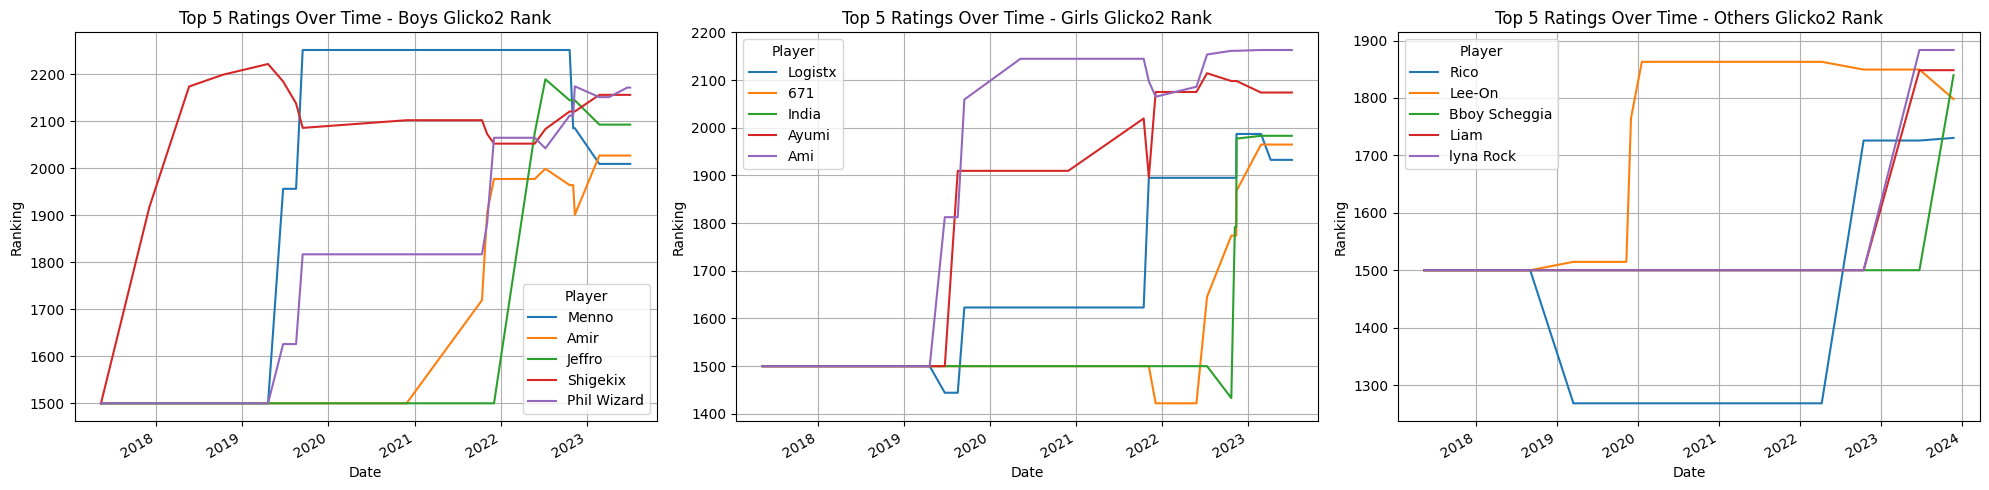

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot each model's top ratings horizontally
plot_top_ratings_glicko(axes[0], boy_glicko_rank[boy_glicko_rank['key'].isin(boy_top10_glicko['key'].to_list())], 'Boys Glicko2 Rank')
plot_top_ratings_glicko(axes[1], girl_glicko_rank[girl_glicko_rank['key'].isin(girl_top10_glicko['key'].to_list())], 'Girls Glicko2 Rank')
plot_top_ratings_glicko(axes[2], other_glicko_rank[other_glicko_rank['key'].isin(other_top10_glicko['key'].to_list())], 'Others Glicko2 Rank')
plt.tight_layout()
plt.show()


In [ ]:
print(classification_report(X_girl["label"], g_model_glicko.predict(X_girl)))

              precision    recall  f1-score   support

           0       0.57      0.72      0.64       382
           1       0.71      0.56      0.63       469

    accuracy                           0.63       851
   macro avg       0.64      0.64      0.63       851
weighted avg       0.65      0.63      0.63       851



In [ ]:
print(classification_report(X_boy["label"], b_model_glicko.predict(X_boy)))

              precision    recall  f1-score   support

           0       0.56      0.79      0.66       694
           1       0.64      0.39      0.48       692

    accuracy                           0.59      1386
   macro avg       0.60      0.59      0.57      1386
weighted avg       0.60      0.59      0.57      1386



In [ ]:
print(classification_report(X_other["label"], o_model_glicko.predict(X_other)))

              precision    recall  f1-score   support

           0       0.52      0.82      0.64       176
           1       0.45      0.16      0.23       160

    accuracy                           0.51       336
   macro avg       0.48      0.49      0.43       336
weighted avg       0.48      0.51      0.44       336



In [ ]:
boy_glicko_rank[boy_glicko_rank['key'].isin(boy_top10_glicko['key'].to_list())]
girl_glicko_rank[girl_glicko_rank['key'].isin(girl_top10_glicko['key'].to_list())]
other_glicko_rank[other_glicko_rank['key'].isin(other_top10_glicko['key'].to_list())]

,key,rating,valid_from,valid_to,ranking,deviation,volatility
24,Marox,"(1500.0, 350.0, 0.06)",2017-05-11,2018-04-07,1500.000000,350.000000,0.060000
25,Marox,"(1662.3108949761174, 290.3189646747521, 0.06)",2018-04-07,2018-04-07,1662.310895,290.318965,0.060000
26,Marox,"(1554.5476432507326, 244.29757298606506, 0.059...",2018-04-07,2018-04-07,1554.547643,244.297573,0.059999
27,Marox,"(1678.060100098176, 218.31960158442098, 0.0600...",2018-04-07,2018-09-01,1678.060100,218.319602,0.060000
28,Marox,"(1572.3816807960548, 203.12291818148705, 0.060...",2018-09-01,2019-03-15,1572.381681,203.122918,0.060001
...,...,...,...,...,...,...,...
871,Kid Kong,"(1672.5594722484702, 218.73890085988907, 0.059...",2023-06-24,NaT,1672.559472,218.738901,0.059999
910,Sean,"(1500.0, 350.0, 0.06)",2017-05-11,2023-06-24,1500.000000,350.000000,0.060000
911,Sean,"(1668.9381929451254, 275.86130044209125, 0.06)",2023-06-24,2023-06-24,1668.938193,275.861300,0.060000
912,Sean,"(1571.6813697455923, 239.69567348805785, 0.059...",2023-06-24,2023-06-24,1571.681370,239.695673,0.059999


In [ ]:
# Filter the DataFrames based on 'key' being in their respective top10 lists
filtered_boy = boy_glicko_rank[boy_glicko_rank['key'].isin(boy_top10_glicko['key'].to_list())].copy()
filtered_girl = girl_glicko_rank[girl_glicko_rank['key'].isin(girl_top10_glicko['key'].to_list())].copy()
filtered_other = other_glicko_rank[other_glicko_rank['key'].isin(other_top10_glicko['key'].to_list())].copy()


filtered_boy['source'] = 'boy'
filtered_girl['source'] = 'girl'
filtered_other['source'] = 'other'


combined_glicko = pd.concat([filtered_boy, filtered_girl, filtered_other], ignore_index=True)


In [ ]:
pd.DataFrame(data={'Elo_boys':boy_top10['key'].to_numpy(), 'Glicko_boys': boy_top10_glicko['key'].to_numpy(),
                   'Elo_girls': girl_top10['key'].to_numpy(), 'Glicko_girls': girl_top10_glicko['key'].to_numpy(),
                   'Elo_Other':other_top10['key'].to_numpy(), 'Glicko_other': other_top10_glicko['key'].to_numpy() })

,Elo_boys,Glicko_boys,Elo_girls,Glicko_girls,Elo_Other,Glicko_other
0,Shigekix,Phil Wizard,Ami,Ami,Lee-On,lyna Rock
1,Phil Wizard,Shigekix,Ayumi,Ayumi,Bboy Scheggia,Bboy Scheggia
2,Amir,Jeffro,671,671,lyna Rock,Liam
3,Dany Dann,Amir,India,India,Liam,Lee-On
4,Jeffro,Wing,Sunny,Logistx,Tik,Rico
5,Kuzya,Menno,Alessandrina,Sunny,Rico,Jaron
6,Gravity,Kuzya,Anti,Kimie,Marox,Kid Kong
7,Lee,Gravity,Kimie,Riko,Jaron,Marox
8,Menno,Lee,Ayane,koharu,Sean,Tik
9,Lil Zoo,Dany Dann,Jilou,Little Sofy,Ryan King,Sean


In [ ]:
combined_glicko.head(3)

,key,rating,valid_from,valid_to,ranking,deviation,volatility,source
0,Amir,"(1500.0, 350.0, 0.06)",2017-05-11,2021-10-14,1500.000000,350.000000,0.060000,boy
1,Amir,"(1662.3108949761174, 290.3189646747521, 0.06)",2021-10-14,2021-10-14,1662.310895,290.318965,0.060000,boy
2,Amir,"(1750.5421120164501, 256.3451719903071, 0.0599...",2021-10-14,2021-10-14,1750.542112,256.345172,0.059999,boy


Top 10 breakers by breaker gender group

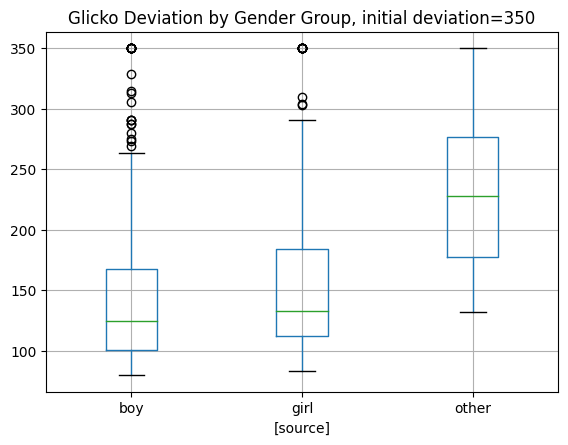

In [ ]:
combined_glicko[['source', 'deviation']].boxplot(by='source')
# Add a title to the plot
plt.title('Glicko Deviation by Gender Group, initial deviation=350')
plt.suptitle('')

# Show the plot
plt.show()

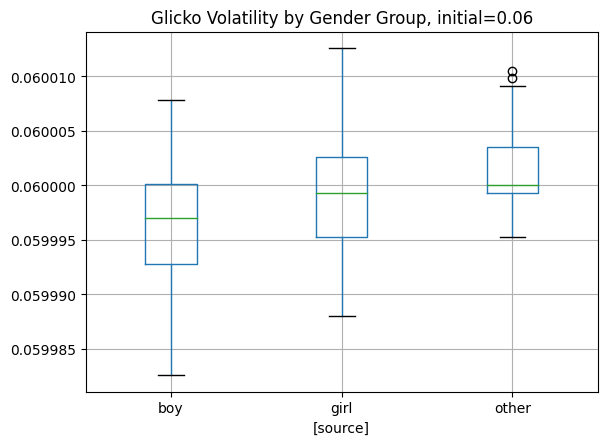

In [ ]:
combined_glicko[['source', 'volatility']].boxplot(by='source')
# Add a title to the plot
plt.title('Glicko Volatility by Gender Group, initial=0.06')
plt.suptitle('')

# Show the plot
plt.show()

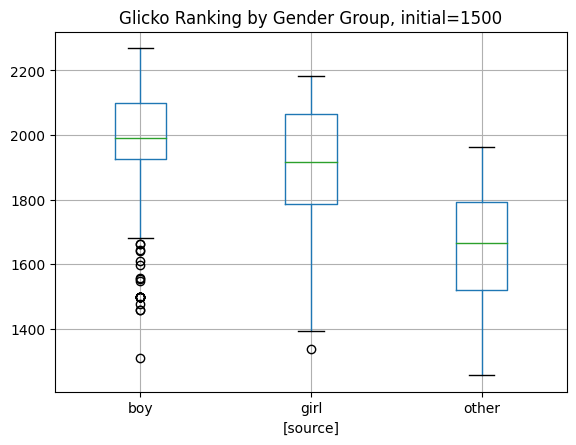

In [ ]:
combined_glicko[['source', 'ranking']].boxplot(by='source')
# Add a title to the plot
plt.title('Glicko Ranking by Gender Group, initial=1500')
plt.suptitle('')

# Show the plot
plt.show()

In [ ]:
combined_glicko.groupby(by='source').agg({'key': 'count', 'ranking': np.mean, 'deviation': np.mean, 'volatility': np.mean})

,key,ranking,deviation,volatility
source,,,,
boy,324,1980.105413,147.055494,0.059996
girl,242,1891.970890,157.464825,0.059999
other,69,1662.587287,233.225971,0.060001
